In [2]:
%matplotlib inline

# %matplotlib qt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os, sys, pathlib, shlex, subprocess
import xbout
import scipy
import xhermes
from xhermes import *


sys.path.append(r"/users/jpm590/2dspace/post-processing/sdtools/")


from hermes3.utils import *


from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.selectors import *

%load_ext autoreload
%autoreload 2
print("Done")


Done


In [3]:
db = CaseDB(
    # case_dir = r"/users/jpm590/2dspace/run",    
    case_dir = r"/users/jpm590/scratch/",
    grid_dir = r"/users/jpm590/2dspace/hermes-3/build-mc-master"
)

toload = [
    # dict(name="original", id="251007-2D-MASTU", unnormalise_geom = True, use_xhermes = True, squash = True)
    dict(name="MAST-U", id="251105-pump-0.95", unnormalise_geom = True, use_xhermes = True, squash = True)

]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()
    
# m = cs["MAST-U"].ds

- Reading case 251105-pump-0.95
-----------------------
- Looking for squash file
- Squash file found. squash date 11/10/2025, 13:18:14, dmp file date 11/08/2025, 08:04:01

Unnormalising with xHermes


### Nd evolution

number of frames (total number of timestep) = 100
t = 1207
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
t = 1207
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
t = 1206
[ 3.04609239  3.04609241  3.14441653  3.4808389   4.22573403  6.25537532
 48.55215378 40.10790794 26.95435009 28.21790045 31.43046058 47.16731726
 45.76772981  5.58601979  3.62168561  2.88895147  2.53529667  2.3585013
  2.30153719  2.34689131  2.49999953  2.80583794  3.38482013  4.81024281
 13.21489248 23.07360254 35.94894103 25.05213641  0.69870318  0.13085097
  0.        ]
t = 1205
[ 3.21742036  3.2174208   3.27448142  3.46325454  3.82967512  4.4996442
  5.96803488 10.35233745 73.98114088 38.18317408 26.71326818 12.48861177
  5.95187167  4.15846196  3.39552748  2.95654607  2.68798077  2.53791376
  2.48747025  2.52230728  2.63338177  2.82670029  3.11327364  3.55772119
  4.43487202  6.86697657 10.19925849  5.72000581  0.8

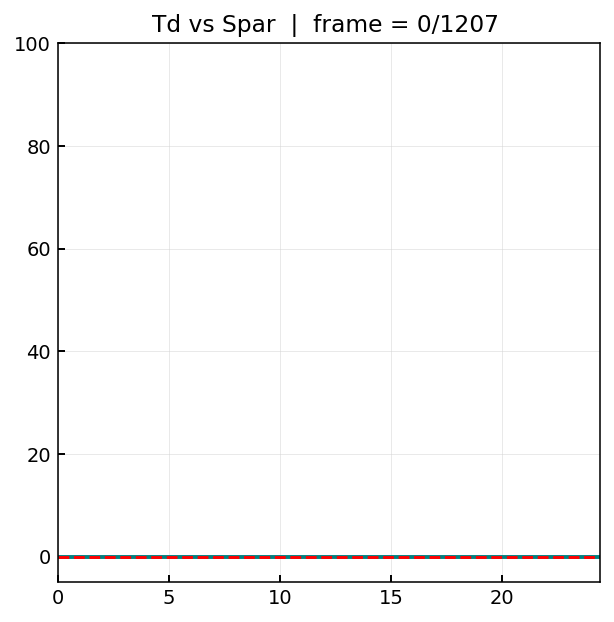

In [35]:
# Get coordinate
# ds_all = cs["original"].ds
ds_all = cs["MAST-U"].ds

t_vals = ds_all.t.values
total_time = len(t_vals)
n_frames =  100# len(t_vals)
print(f"number of frames (total number of timestep) = {n_frames}")
fig, ax = plt.subplots(figsize = (5,5))

line, = ax.plot([], [], lw=2)
ax.set_xlim()

def update(frame_idx):
    
    t_val = float(t_vals[frame_idx])
    # print(f"Using time = {t_val}, frame_idx = {frame_idx}")
    print(f"t = {total_time - frame_idx}")
    ts = int(total_time - frame_idx)
    # ds_i = ds_all.isel(t=ts-1)
    ds_i = ds_all.sel(t=t_val)

    
    df_fieldline = get_1d_poloidal_data(
        ds_i, 
        params = ["Te", "Td+", "Td"], 
        region = "outer_lower", 
        sepadd=1
    )
    
    x = df_fieldline["Spar"].values[::-1]
    y = df_fieldline["Td"]
    print(y.values)

    line.set_data(x,y)
    # dynamic axis scaling
    ax.set_ylim(-5, 100)
    ax.set_xlim(0, df_fieldline["Spar"].max())
    ax.set_title(f"Td vs Spar  |  frame = {frame_idx}/{total_time} ")
    # ax.set_title(f"Td vs Spar  |  frame = {total_time - frame_idx}/{total_time} ")



    # print(f"Nd vs Spar  |  t = {t_val:.6e} s")
    return line,

ax.grid(True, alpha=0.5)
ax.axhline(y=0, color='r', ls='--')
# ax.set_yscale("log")

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=0.0001, blit = False)
# HTML(ani.to_jshtml())
ani.save(filename="nd_vs_spar.gif", writer="pillow", fps=5)



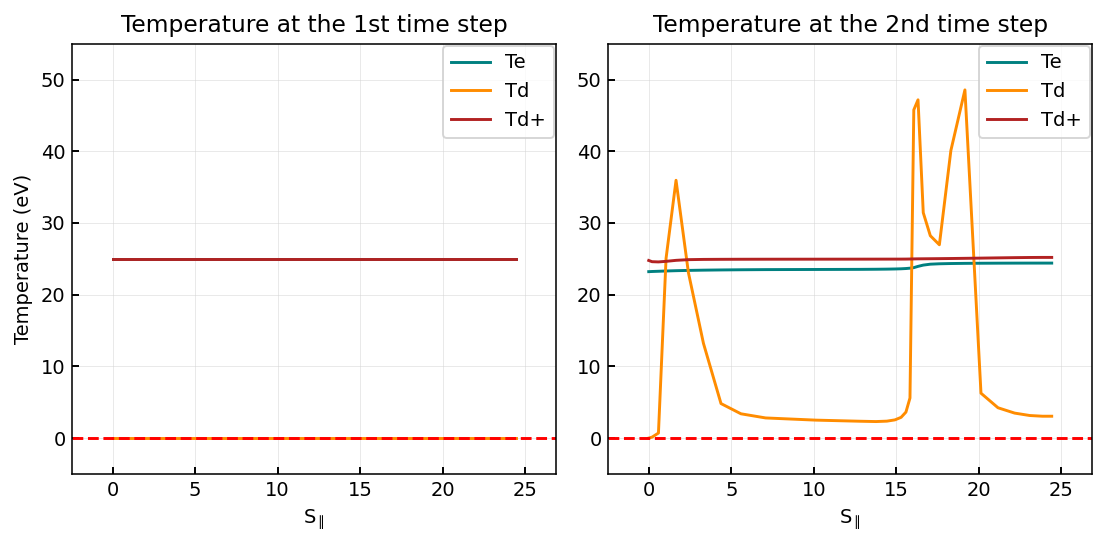

In [61]:
# Plot the first and second frame

fig, ax = plt.subplots(1,2, figsize = (8,4))
ds_1 = ds_all.isel(t=0)
ds_2 = ds_all.isel(t=1)

    
df_f1 = get_1d_poloidal_data(ds_1, params = ["Te", "Td+", "Td"], region = "outer_lower", sepadd=1)
df_f2 = get_1d_poloidal_data(ds_2, params = ["Te", "Td+", "Td"], region = "outer_lower", sepadd=1)


ax[0].plot(df_f1["Spar"].values[::-1], df_f1["Te"], label="Te")
ax[0].plot(df_f1["Spar"].values[::-1], df_f1["Td"], label="Td")
ax[0].plot(df_f1["Spar"].values[::-1], df_f1["Td+"], label="Td+")
ax[1].plot(df_f2["Spar"].values[::-1], df_f2["Te"], label="Te")
ax[1].plot(df_f2["Spar"].values[::-1], df_f2["Td"], label="Td")
ax[1].plot(df_f2["Spar"].values[::-1], df_f2["Td+"], label="Td+")

ax[0].set_title("Temperature at the 1st time step")
ax[0].set_xlabel("$S_{\\parallel}$")
ax[1].set_xlabel("$S_{\\parallel}$")
ax[1].set_title("Temperature at the 2nd time step")

ax[0].set_ylabel("Temperature (eV)")
ax[0].set_ylim(-5,55)
ax[0].axhline(y=0, color='r', ls='--')
ax[1].axhline(y=0, color='r', ls='--')

ax[1].set_ylim(-5,55)
ax[0].legend()
ax[1].legend()

ax[0].grid(True, alpha = 0.5)
ax[1].grid(True, alpha = 0.5)

plt.tight_layout()



### Check if there is 0 in the array of Td


In [ ]:
ds_all = cs["MAST-U"].ds

t_vals = ds_all.t.values
total_time = len(t_vals)

for i in range(total_time):
    print(i)
    ds_i = ds_all.isel(t=i)
    arr_Td = ds_i["Td"].values
    arr_Nd = ds_i["Nd"].values
    arr_Pd = ds_i["Pd"].values


    # df_f1 = get_1d_poloidal_data(ds_i, params = ["Te", "Td+", "Td"], region = "outer_lower", sepadd=1)
    # arr = df_f1["Td"].values

    Td_hit_floor = np.any(arr_Td <= 0.1)
    if Td_hit_floor:
        print(f"at time {i}, Td has value <= 0.1 eV")
        print(arr_Td)
        
    Nd_hit_floor = np.any(arr_Nd <= 1e10)
    if Td_hit_floor:
        print(f"at time {i}, Nd has value <= 1e-7 * 1e17 = 1e10 (1/m^3)")
        print(arr_Td)
        
    Pd_hit_floor = np.any(arr_Pd <= 1e9 * 1.62e-19)
    if Td_hit_floor:
        print(f"at time {i}, Td has value <= 0.1 eV * 1e10 (1/m3) = 1e9 * 1.62e-19 [Pa]")
        print(arr_Td)
        
        

    


0
at time 0, Td has value <= 0.1 eV
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
at time 0, Nd has value <= 1e-7 * 1e17 = 1e10 (1/m^3)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
at time 0, Td has value <= 0.1 eV * 1e-7 (1/m3) = 1e9 * 1.62e-19 [Pa]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1
at time 1, Td has value <= 0.1 eV
[[0.09023049 0.         0.         ... 0.         0.         0.30704662]
 [0.11512197 0.         0.         ... 0.         0.         0.35226322]
 [0.11512197 0.         0.         ... 0.         0.         0.35226322]
 ...
 [0.13873798 0.         0.         ... 0.         0.         0.20813739]
 [0.13873798 0.         0.         ... 

at time 3, Td has value <= 0.1 eV
[[8.15595927e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.91046692e-01]
 [1.05851411e-01 0.00000000e+00 0.00000000e+00 ... 1.64061077e-08
  1.64061077e-08 4.87539775e-01]
 [1.05851411e-01 0.00000000e+00 0.00000000e+00 ... 1.64061077e-08
  1.64061077e-08 4.87539775e-01]
 ...
 [1.27832878e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.09665132e-01]
 [1.27832878e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 2.09665132e-01]
 [1.06798616e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.93611090e-01]]
at time 3, Nd has value <= 1e-7 * 1e17 = 1e10 (1/m^3)
[[8.15595927e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.91046692e-01]
 [1.05851411e-01 0.00000000e+00 0.00000000e+00 ... 1.64061077e-08
  1.64061077e-08 4.87539775e-01]
 [1.05851411e-01 0.00000000e+00 0.00000000e+00 ... 1.64061077e-08
  1.64061077e-08 4.87539775e-01]
 ...
 [1.278328

### Check if there is < 1e10 in the array of Nd


In [ ]:
ds_all = cs["MAST-U"].ds

t_vals = ds_all.t.values
total_time = len(t_vals)

for i in range(total_time):
    print(i)
    ds_i = ds_all.isel(t=i)
    

    hit_floor = np.any(arr < 1e10 )
    if hit_floor:
        print(f"at time {i}, Nd is less than 1e10, hit the floor!")
        print(arr)
        # ax.plot(df_f1["Spar"].values[::-1], df_f1["Td"])

0
at time 0, Nd is less than 1e10, hit the floor!
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1
2
3
4


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


### Check if there is < 1e10 in the array of Pd


In [54]:
ds_all = cs["MAST-U"].ds

t_vals = ds_all.t.values
total_time = len(t_vals)

for i in range(total_time):
    print(i)
    ds_i = ds_all.isel(t=i)
    arr = ds_i["Pd"].values
    
    # df_f1 = get_1d_poloidal_data(ds_i, params = ["Pe", "Pd+", "Pd"], region = "outer_lower", sepadd=1)
    # arr = df_f1["Pd"].values

    hit_floor = np.any(arr < 1e9 * 1.62e-19 )
    if hit_floor:
        print(f"at time {i}, Pd is less than 1e9 (0.1 eV * 1e10 1/m3), hit the floor!")
        print(arr)
        # ax.plot(df_f1["Spar"].values[::-1], df_f1["Td"])

0
at time 0, Pd is less than 1e9 (0.1 eV * 1e10 1/m3), hit the floor!
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1
at time 1, Pd is less than 1e9 (0.1 eV * 1e10 1/m3), hit the floor!
[[0.00379824 0.         0.         ... 0.         0.         0.0046388 ]
 [0.00486057 0.         0.         ... 0.         0.         0.0064693 ]
 [0.00486057 0.         0.         ... 0.         0.         0.0064693 ]
 ...
 [0.00474278 0.         0.         ... 0.         0.         0.00342398]
 [0.00474278 0.         0.         ... 0.         0.         0.00342398]
 [0.00356303 0.         0.         ... 0.         0.         0.00236413]]
2
at time 2, Pd is less than 1e9 (0.1 eV * 1e10 1/m3), hit the floor!
[[5.13922766e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 6.88074089e-03]
 [6.14458761e-03 0.00000000e+00 0.00000000e+00 ... 1.75851510e-05
  1.75851510e-05 8.003956

at time 4, Pd is less than 1e9 (0.1 eV * 1e10 1/m3), hit the floor!
[[8.27477921e-03 0.00000000e+00 0.00000000e+00 ... 6.91717667e-03
  6.91717667e-03 1.15796492e-02]
 [6.09109864e-03 2.52025274e-06 2.52025274e-06 ... 6.91453562e-03
  6.91453562e-03 1.07932534e-02]
 [6.09109864e-03 2.52025274e-06 2.52025274e-06 ... 6.91453562e-03
  6.91453562e-03 1.07932534e-02]
 ...
 [7.61562924e-03 1.51076956e-05 1.51076956e-05 ... 0.00000000e+00
  0.00000000e+00 8.69047156e-03]
 [7.61562924e-03 1.51076956e-05 1.51076956e-05 ... 0.00000000e+00
  0.00000000e+00 8.69047156e-03]
 [9.13193565e-03 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 8.11744623e-03]]
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
